In [8]:
import os

def read_dataset(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            label, text = line.split(' ', 1)
            text=re.sub(r'[^a-zA-Z\s]','',text)
            text=re.sub(r'\s+',' ',text)
            text=text.lower()
            data.append((label.strip(), text.strip()))
    return data

def preprocess(text):
    text = text.lower()
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    return text

def print_statistics(dataset, dataset_type):
    num_samples = len(dataset)
    num_positive = sum(1 for label, _ in dataset if label == '__label__2')
    num_negative = sum(1 for label, _ in dataset if label == '__label__1')
    print(f"{dataset_type.capitalize()} dataset statistics:")
    print(f"Number of samples: {num_samples}")
    print(f"Number of positive samples: {num_positive}")
    print(f"Number of negative samples: {num_negative}")
    print(f"Positive ratio: {num_positive / num_samples:.2f}")
    print(f"Negative ratio: {num_negative / num_samples:.2f}")

train_file_path = '/Users/siriduggineni/Downloads/archive-2/train.ft.txt'
test_file_path = '/Users/siriduggineni/Downloads/archive-2/test.ft.txt'

train_dataset = read_dataset(train_file_path)
test_dataset = read_dataset(test_file_path)

train_dataset = [(label, preprocess(text)) for label, text in train_dataset]
test_dataset = [(label, preprocess(text)) for label, text in test_dataset]

print_statistics(train_dataset, "train")
print()
print_statistics(test_dataset, "test")


Train dataset statistics:
Number of samples: 3600000
Number of positive samples: 1800000
Number of negative samples: 1800000
Positive ratio: 0.50
Negative ratio: 0.50

Test dataset statistics:
Number of samples: 400000
Number of positive samples: 200000
Number of negative samples: 200000
Positive ratio: 0.50
Negative ratio: 0.50


In [11]:
pip install matplotlib wordcloud


  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/ac/66/937d1d73389c0b501c928c4d8513653063d2b40272dff70d0e283d8b9144/wordcloud-1.9.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 2.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


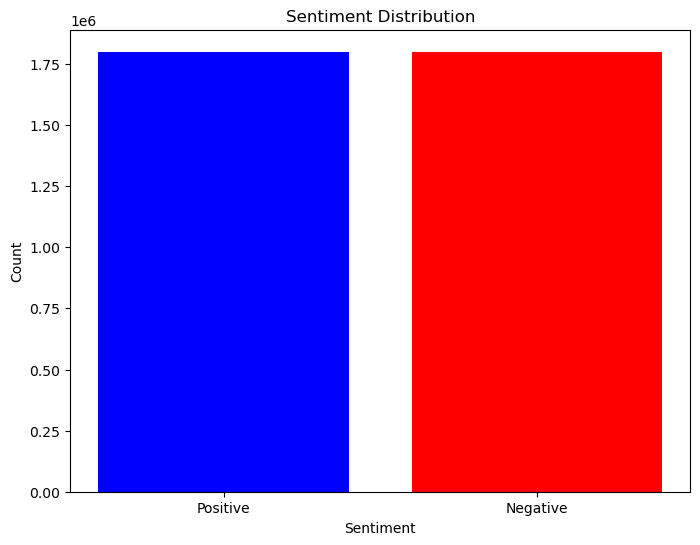

In [12]:
labels = [label for label, _ in train_dataset]
positive_count = sum(1 for label in labels if label == '__label__2')
negative_count = sum(1 for label in labels if label == '__label__1')

plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [positive_count, negative_count], color=['blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

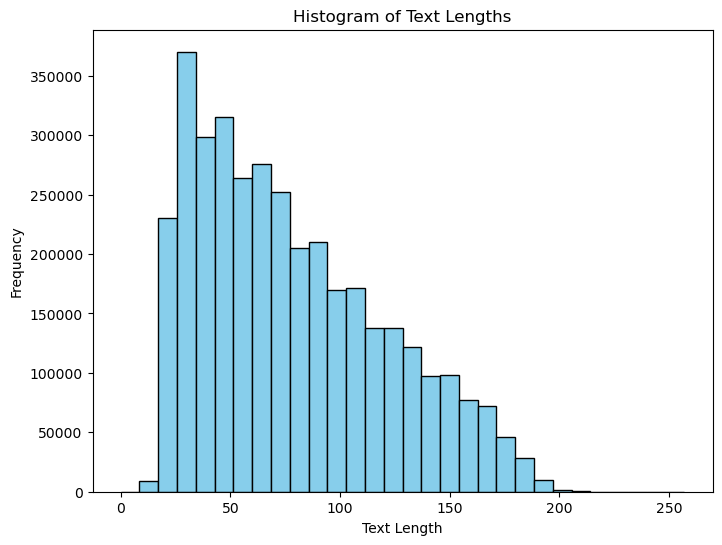

In [4]:
text_lengths = [len(text.split()) for _, text in train_dataset]
plt.figure(figsize=(8, 6))
plt.hist(text_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

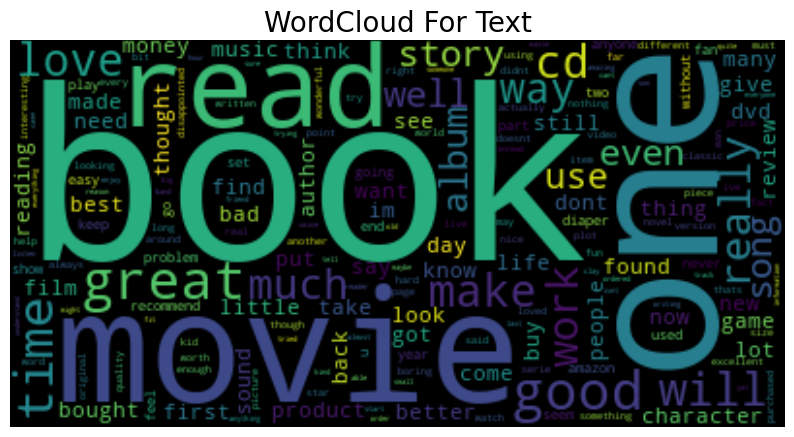

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_data = " ".join(text for _, text in train_dataset[:20000])

wordcloud = WordCloud().generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud For Text", fontsize=20)
plt.show()


In [22]:
train_texts = [text for _, text in train_dataset]
train_labels = [label for label, _ in train_dataset]

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


voc_size = 20000
tokenizer=Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
max_sequence_length = 100
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

train_labels = np.array([1 if label == '__label__2' else 0 for label in train_labels])

X_train, X_val, y_train, y_val = train_test_split(train_sequences_padded, train_labels, test_size=0.2, random_state=42)

test_texts = [text for _, text in test_dataset]
test_labels = [label for label, _ in test_dataset]

test_sequences = tokenizer.texts_to_sequences(test_texts)
X_test = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

y_test = np.array([1 if label == '__label__2' else 0 for label in test_labels])

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (2880000, 100) (2880000,)
Validation set shape: (720000, 100) (720000,)
Testing set shape: (400000, 100) (400000,)


In [5]:
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import bz2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint
import pickle


In [25]:

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (2880000, 100) (2880000,)
Validation set shape: (720000, 100) (720000,)
Testing set shape: (400000, 100) (400000,)


In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SpatialDropout1D

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=64, input_length=max_sequence_length))
model.add(LSTM(64, return_sequences=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))



In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_val, y_val))

model.save_weights('lstm_model_weights.h5')


Epoch 1/2
45000/45000 [==============================] - 2982s 66ms/step - loss: 0.2350 - accuracy: 0.9024 - val_loss: 0.1601 - val_accuracy: 0.9386
Epoch 2/2
45000/45000 [==============================] - 3074s 68ms/step - loss: 0.1502 - accuracy: 0.9432 - val_loss: 0.1485 - val_accuracy: 0.9438


In [30]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


12500/12500 [==============================] - 123s 10ms/step - loss: 0.1505 - accuracy: 0.9429
Test Loss: 0.1505
Test Accuracy: 0.9429


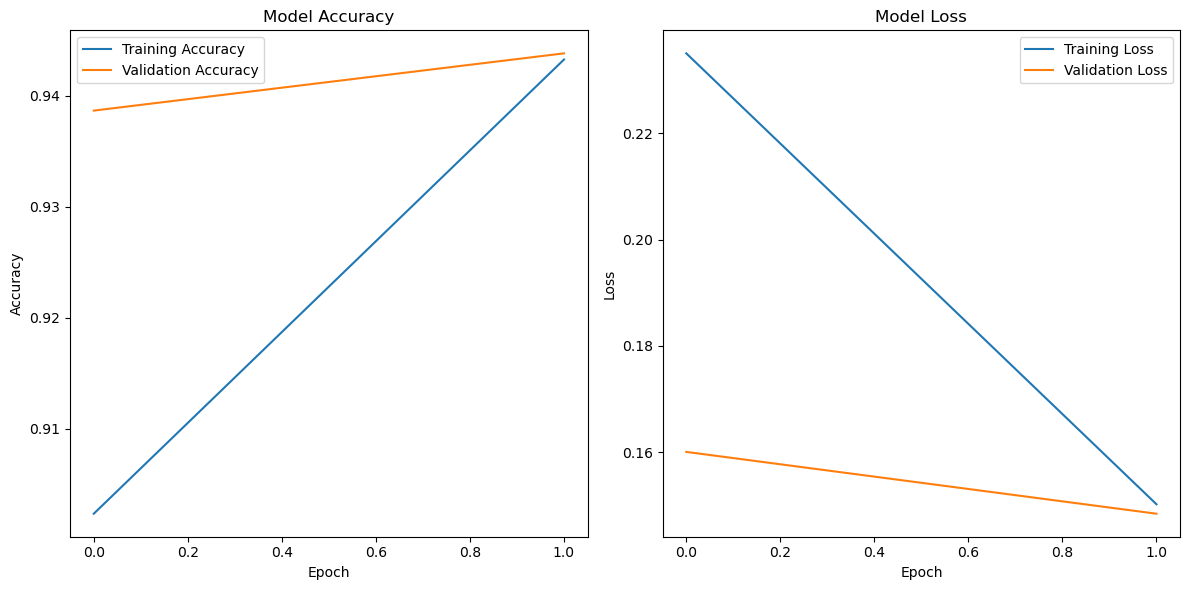

In [31]:
plt.figure(figsize=(12, 6))
    
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=64, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(16)))
model.add(Dense(1, activation='sigmoid'))

In [39]:
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 64)           1280000   
                                                                 
 spatial_dropout1d_5 (Spati  (None, 100, 64)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_3 (Bidirecti  (None, 100, 128)          66048     
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 64)           41216     
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 32)                10368     
 onal)                                                

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_val, y_val))

model.save_weights('bi_lstm_model_weights.h5')


Epoch 1/2
45000/45000 [==============================] - 3935s 87ms/step - loss: 0.1855 - accuracy: 0.9276 - val_loss: 0.1540 - val_accuracy: 0.9415
Epoch 2/2
45000/45000 [==============================] - 5178s 115ms/step - loss: 0.1477 - accuracy: 0.9442 - val_loss: 0.1437 - val_accuracy: 0.9458


In [41]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


12500/12500 [==============================] - 255s 20ms/step - loss: 0.1466 - accuracy: 0.9448
Test Loss: 0.1466
Test Accuracy: 0.9448


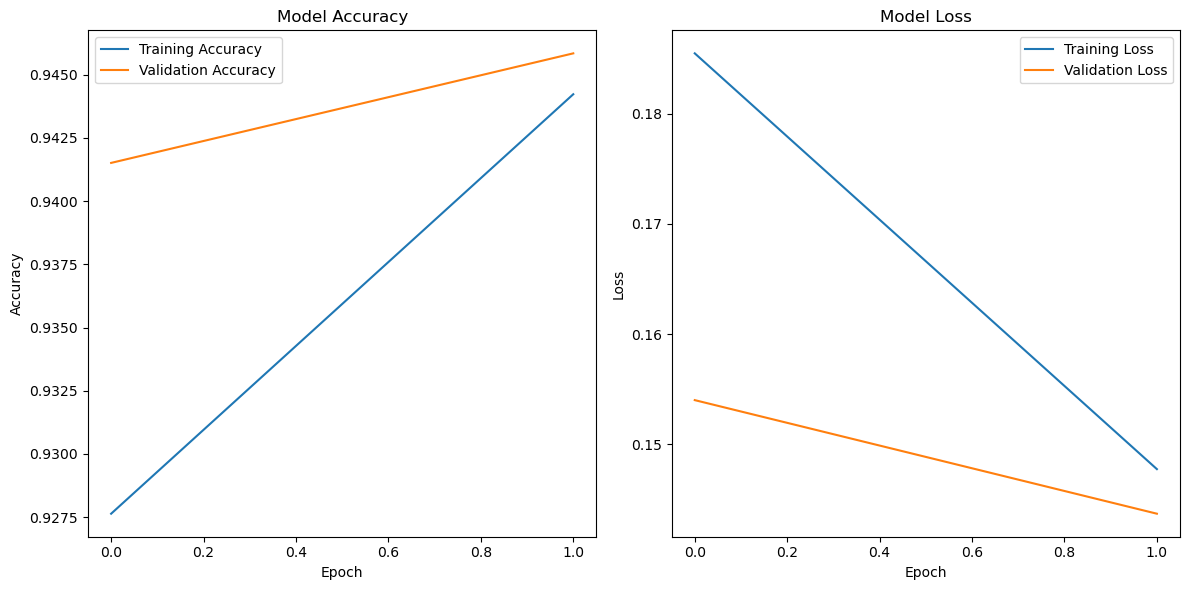

In [42]:
plt.figure(figsize=(12, 6))
    
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
